# Comparing models

In this notebook, we will compare the three models we've trained using:

- Aggregate metrics
- Performance visualizations
- Dataset visualization

First, we load data and the three existing models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
np.random.seed(35)
import warnings
warnings.filterwarnings('ignore')

from ml_editor.data_processing import (
    format_raw_df,
    get_split_by_author,
    get_vectorized_series, 
    get_feature_vector_and_label
)
from ml_editor.model_evaluation import get_feature_importance, get_calibration_plot
from ml_editor.model_v2 import POS_NAMES

data_path = Path('../data/writers_with_features.csv')
df = pd.read_csv(data_path)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/haesun/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
clf_1 = joblib.load(Path("../models/model_1.pkl")) 
vectorizer_1 = joblib.load(Path("../models/vectorizer_1.pkl")) 
clf_2 = joblib.load(Path("../models/model_2.pkl"))
vectorizer_2 = joblib.load(Path("../models/vectorizer_2.pkl")) 

# clf_3 does not vectorize text
clf_3 = joblib.load(Path("../models/model_3.pkl")) 

In [3]:
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

We then score the test data using all three models.

In [4]:
train_df["vectors"] = get_vectorized_series(train_df["full_text"].copy(), vectorizer_1)
test_df["vectors"] = get_vectorized_series(test_df["full_text"].copy(), vectorizer_1)

features_1 = [
                "action_verb_full",
                "question_mark_full",
                "text_len",
                "language_question",
            ]

features_2 = ["num_questions", 
               "num_periods",
               "num_commas",
               "num_exclam",
               "num_quotes",
               "num_colon",
               "num_stops",
               "num_semicolon",
               "num_words",
               "num_chars",
               "num_diff_words",
               "avg_word_len",
               "polarity"
              ]
features_2.extend(POS_NAMES.keys())

X_test_1, y_test = get_feature_vector_and_label(test_df, features_1)
X_test_2, y_test = get_feature_vector_and_label(test_df, features_2)
X_test_3 = test_df[features_2].astype(float)

In [5]:
clf1_predicted_proba = clf_1.predict_proba(X_test_1)
clf2_predicted_proba = clf_2.predict_proba(X_test_2)
clf3_predicted_proba = clf_3.predict_proba(X_test_3)

clf1_predicted = clf_1.predict(X_test_1)
clf2_predicted = clf_2.predict(X_test_2)
clf3_predicted = clf_3.predict(X_test_3)

## Comparing accuracy

First, we can compare aggregate scores

In [6]:
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=True,
                                    average='binary')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=True,
                              average='binary')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=True, average='binary')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

for i, y_predicted in enumerate([clf1_predicted, clf2_predicted, clf3_predicted]):
    accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
    print("Model %s: Validation accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % ((i+1), accuracy, precision, recall, f1))

Model 1: Validation accuracy = 0.611, precision = 0.620, recall = 0.529, f1 = 0.571
Model 2: Validation accuracy = 0.615, precision = 0.657, recall = 0.445, f1 = 0.531
Model 3: Validation accuracy = 0.556, precision = 0.619, recall = 0.239, f1 = 0.345


## Comparing feature importance

Let's look at which features each model leverages next.

In [7]:
def display_importance(clf, feature_names, k=10):
    print("Top %s importances:\n" % k)
    print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, feature_names)[:k]]))

    print("\nBottom %s importances:\n" % k)
    print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, feature_names)[-k:]]))

In [8]:
print("Model 1")
w_indices = vectorizer_1.get_feature_names()
w_indices.extend(features_1)
all_feature_1 = np.array(w_indices)
display_importance(clf_1, all_feature_1)

Model 1
Top 10 importances:

text_len: 0.01
are: 0.0059
what: 0.0058
writing: 0.0051
can: 0.0044
ve: 0.0044
on: 0.0039
do: 0.0038
some: 0.0037
story: 0.0037

Bottom 10 importances:

toes: 0
anyhow: 0
waking: 0
winning: 0
nerves: 0
fifty: 0
newcomer: 0
nightmares: 0
nineteen: 0
instrument: 0


In [9]:
print("Model 2")
w_indices = vectorizer_2.get_feature_names()
w_indices.extend(features_2)
all_feature_2 = np.array(w_indices)
display_importance(clf_2, all_feature_2)

Model 2
Top 10 importances:

num_chars: 0.0083
ADJ: 0.0081
num_periods: 0.0079
num_diff_words: 0.0078
num_commas: 0.0069
num_questions: 0.0068
ADV: 0.0067
AUX: 0.0067
num_words: 0.0067
DET: 0.0065

Bottom 10 importances:

gesture: 0
spirits: 0
giants: 0
gimmick: 0
spinning: 0
spine: 0
glancing: 0
battles: 0
glare: 0
hearts: 0


In [10]:
print("Model 3")
display_importance(clf_3, np.array(features_2))

Model 3
Top 10 importances:

num_questions: 0.048
num_chars: 0.048
num_periods: 0.048
num_diff_words: 0.047
ADJ: 0.047
AUX: 0.044
DET: 0.043
ADV: 0.043
NOUN: 0.043
PUNCT: 0.042

Bottom 10 importances:

PROPN: 0.029
NUM: 0.026
num_colon: 0.022
num_quotes: 0.019
INTJ: 0.014
SYM: 0.014
X: 0.01
num_exclam: 0.0072
num_semicolon: 0.007
CONJ: 0


## Comparing calibration

Next, we'll look at calibration, which is very important in an application were we want to show users meaningful scores representing the quality of their questions.

In [11]:
def get_multiple_calibration_plot(predicted_proba_arrays, true_y, figsize=(10, 8)):
    """
    Inspired by sklearn example
    https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
    :param figsize: size of the output figure
    :param predicted_proba_y: the predicted probabilities of our model for each example
    :param true_y: the true value of the label
    :return: calibration plot
    """

    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
#     print("\tBrier: %1.3f" % clf_score)
    
    for i,predicted_proba_y in enumerate(predicted_proba_arrays):
        fraction_of_positives, mean_predicted_value = calibration_curve(
            true_y, predicted_proba_y, n_bins=10
        )

        ax1.plot(
            mean_predicted_value,
            fraction_of_positives,
            "s-",
            label = "Model %s" % (i + 1)
        )

        ax2.hist(
            predicted_proba_y,
            range=(0, 1),
            bins=10,
            histtype="step",
            label = "Model %s" % (i + 1),
            lw=2,
        )

    ax1.set_ylabel("Fraction of positives")
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.legend(loc="lower right")
    ax1.set_title("Calibration plot")

    ax2.set_title("Probability distribution")
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper right", ncol=2)

    plt.tight_layout()

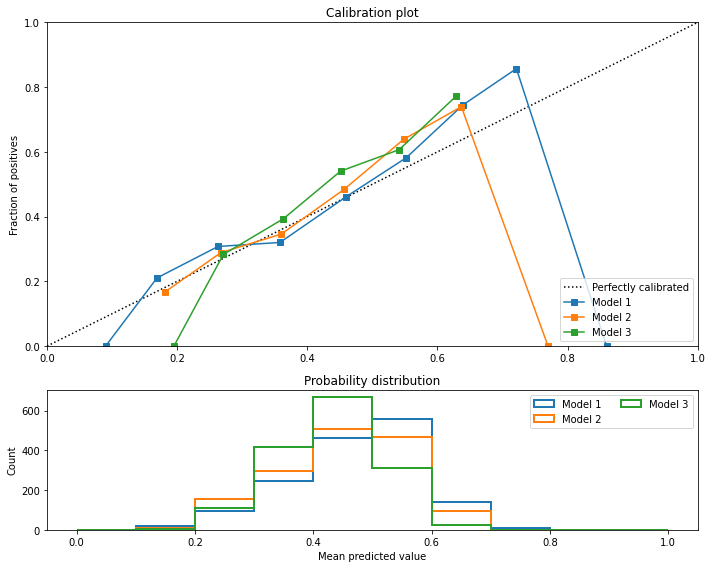

In [12]:
predictions = [clf1_predicted_proba[:,1], clf2_predicted_proba[:,1], clf3_predicted_proba[:,1]]

get_multiple_calibration_plot(predictions, y_test)
plt.savefig('../images/bmlpa_figures/ch07-4.png', dpi=300)

No handles with labels found to put in legend.


	Brier: 0.233


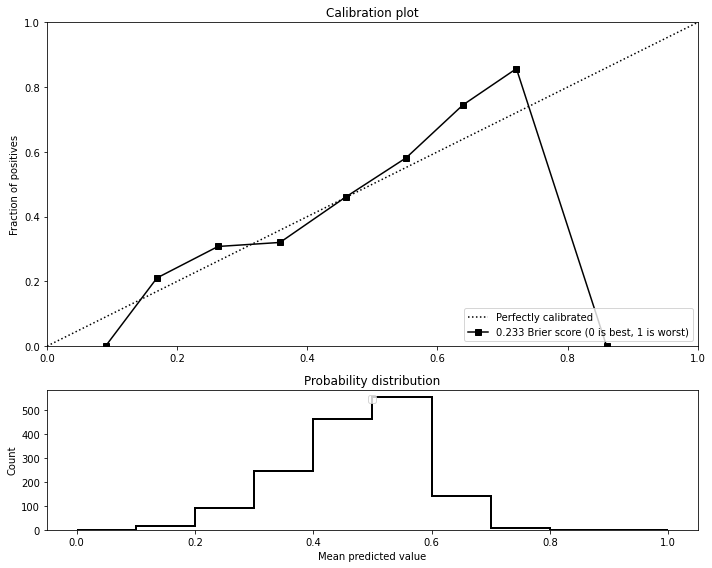

In [13]:
get_calibration_plot(clf1_predicted_proba[:,1], y_test, figsize=(10, 8))

No handles with labels found to put in legend.


	Brier: 0.234


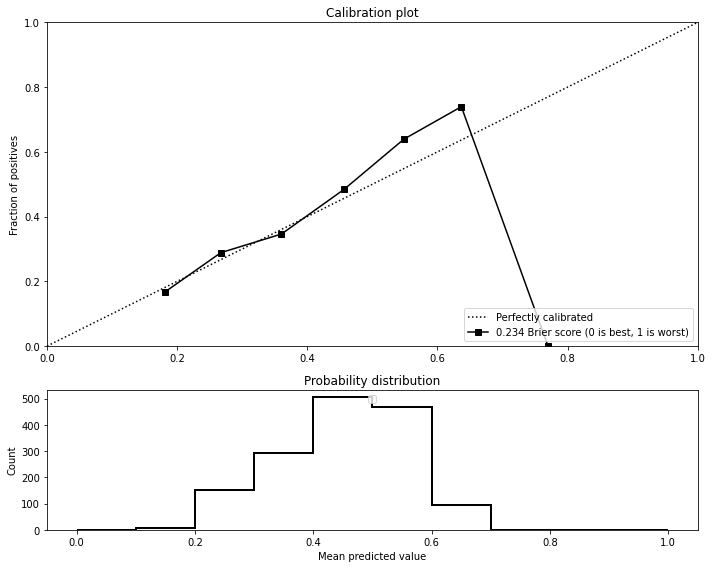

In [14]:
get_calibration_plot(clf2_predicted_proba[:,1], y_test, figsize=(10, 8))
plt.savefig('../images/bmlpa_figures/ch07-3.png', dpi=300)

No handles with labels found to put in legend.


	Brier: 0.243


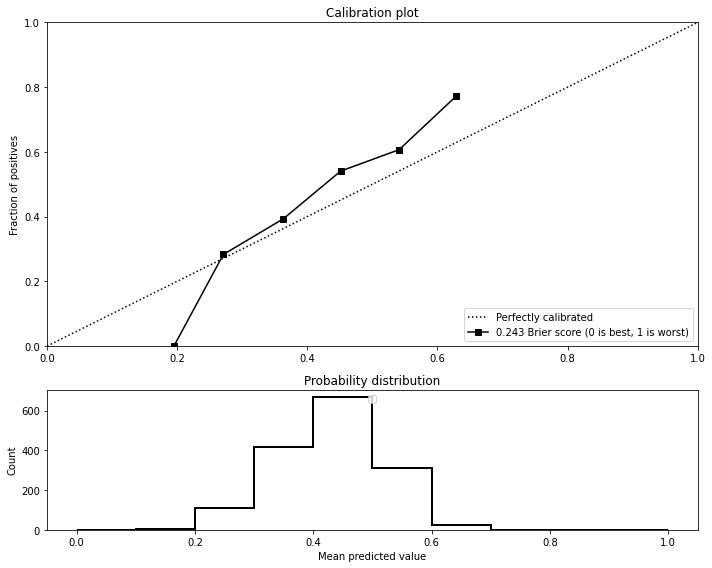

In [15]:
get_calibration_plot(clf3_predicted_proba[:,1], y_test, figsize=(10, 8))

The third model is showing much better calibration, which is crucial to our application since we want the scores we show users to be as meaningful as possible. In addition, the third model is using the most interpretable features, which will allow us to make clear suggestions. We will use it for the ML Editor.